In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# You may also check MinMaxScaler and MaxAbsScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

%matplotlib inline

## Preparing the dataset

### Cleaning data

In [3]:
data = 'greenTripData.csv'
df = pd.read_csv(data)
dfcleaned = df

#Changing date_range from dates into 6 categories ===> count from 1 to 6
dfcleaned['date_range'], unique = pd.factorize(dfcleaned['date_range'])
dfcleaned['date_range'] += 1

#Recalculating trip_duration column to be only in seconds
pickup = pd.to_datetime(df['lpep_pickup_datetime'])
dropoff = pd.to_datetime(df['lpep_dropoff_datetime'])
duration = dropoff - pickup
sec = duration.dt.total_seconds()
dfcleaned['trip_duration'] = sec

#Remove time from 1st 2 columns and keep only the day as it is only unique value
pickup_day = pickup.dt.day
dropoff_day = dropoff.dt.day
dfcleaned['lpep_pickup_datetime'] = pickup_day
dfcleaned['lpep_dropoff_datetime'] = dropoff_day

#Change the pickup_time and dropoff_time to seconds
pickup = pd.to_datetime(df['pickup_time'])
dropoff = pd.to_datetime(df['dropoff_time'])
pickup_seconds = pickup.dt.hour * 3600 + pickup.dt.minute * 60 + pickup.dt.second
dropoff_seconds = dropoff.dt.hour * 3600 + dropoff.dt.minute * 60 + dropoff.dt.second
dfcleaned['pickup_time'] = pickup_seconds
dfcleaned['dropoff_time'] = dropoff_seconds



### Categorizing data

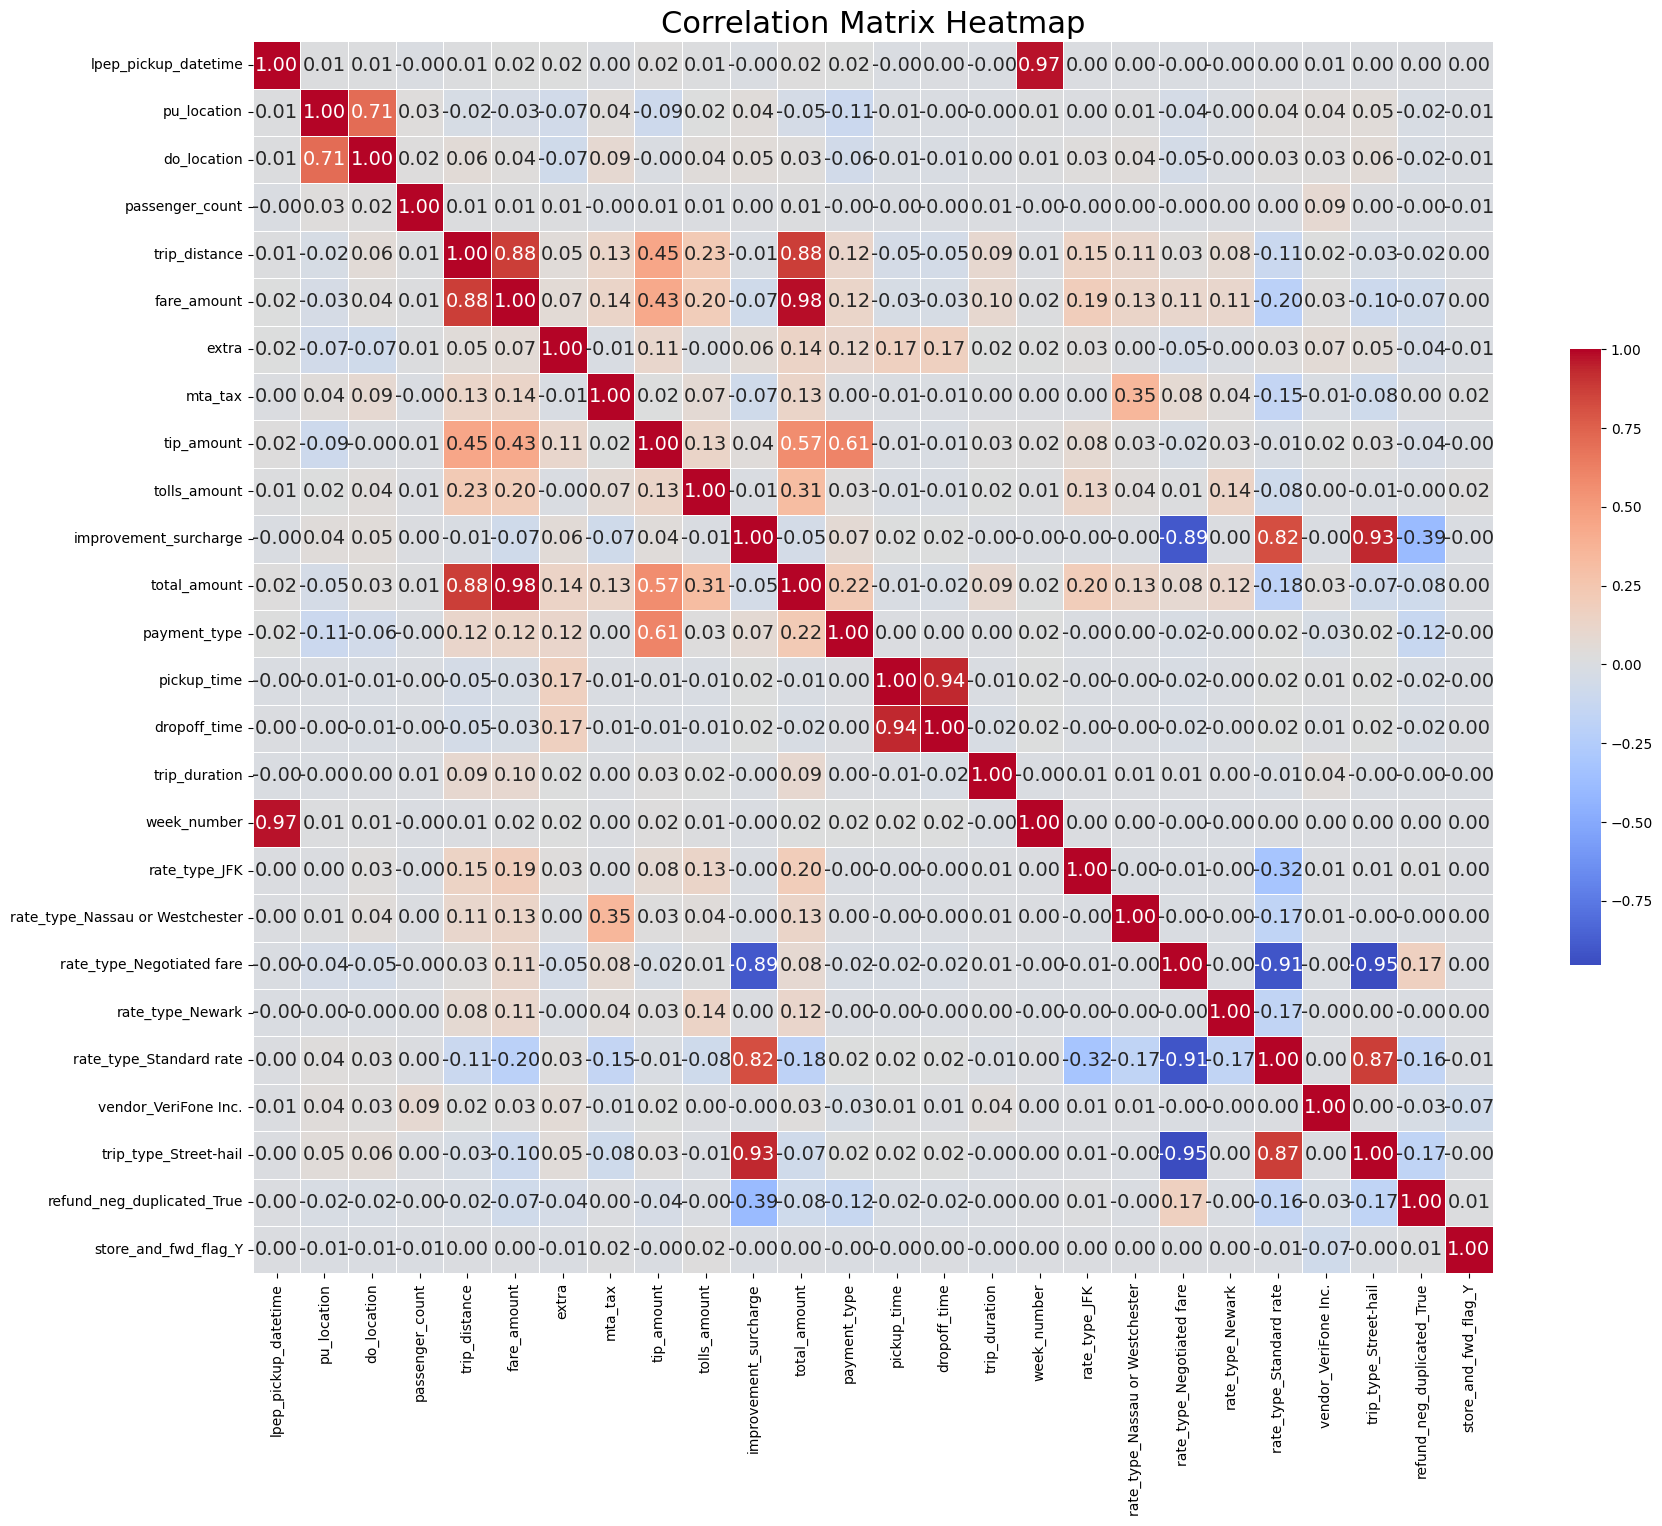

25th percentile: 8.15
50th percentile (median): 11.3
90th percentile: 26.76
0


In [4]:
#removing unwanted columns to adjust correlation 
# these column had correlation = 1 with other colums so we removed them completely
dfcleaned = dfcleaned.drop(columns=['lpep_dropoff_datetime'])
dfcleaned = dfcleaned.drop(columns=['date_range'])

correlation_matrix = dfcleaned.corr()

# Set up the matplotlib figure with an even larger size
plt.figure(figsize=(20, 16))

# Create a heatmap to visualize the correlation matrix
heatmap = sns.heatmap(correlation_matrix, 
                      annot=True, 
                      cmap='coolwarm', 
                      fmt='.2f', 
                      linewidths=.5, 
                      cbar_kws={'shrink': .5},
                      annot_kws={'size': 14})

# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap', size=22)
# Display the heatmap
plt.show()

#Categorizing the data into low, medium, high based on percentiles
#Get percentiles
percentiles = dfcleaned['total_amount'].quantile([0.25, 0.50, 0.90])
print(f"25th percentile: {percentiles[0.25]}")
print(f"50th percentile (median): {percentiles[0.50]}")
print(f"90th percentile: {percentiles[0.90]}")

#remove -ve prices
dfcleaned = dfcleaned[dfcleaned['total_amount'] >= 0].copy()  
below_0_count = (dfcleaned['total_amount'] < 0).sum()
print(below_0_count)

#categorize the data ====> 0:8 --> low , 8:25 --> mid , 25+ --> high
bins = [0, 8, 25, float('inf')]
labels = ['low', 'medium', 'high']
amount_class = pd.cut(dfcleaned['total_amount'], bins=bins, labels=labels, right=False)
dfcleaned['amount_class'] = amount_class


### Split and scale

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variables
df = dfcleaned
X = df.drop(columns=['amount_class'])
X = X.drop(columns=['fare_amount'])
X = X.drop(columns=['total_amount'])
y = df['amount_class']

# Split the data into train (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## KNN

In [6]:
#KNN default parameters trial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.8626680877779562


#### KNN Best Param

In [7]:
# Using grid search to evaluate multiple parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
model = KNeighborsClassifier
model = KNeighborsClassifier()
# Define parameter grid
param_grid = {
    'n_neighbors': [5, 30, 100], 
    'algorithm': ['auto', 'ball_tree', 'brute'], # distance
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=8)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test set score with best parameters: ", test_score)

Best parameters found:  {'algorithm': 'auto', 'n_neighbors': 5}
Best cross-validation score:  0.8869186925707385
Test set score with best parameters:  0.889795739586223


Note that test and cross-validation scores are similar so model is not overfit

#### KNN ROC

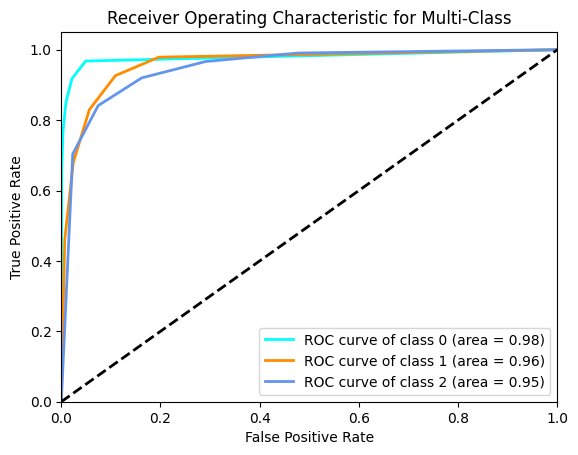

In [8]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined
# Binarize the output (for multi-class)
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Use the OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train_scaled, y_train_binarized)

# Predict probabilities
y_test_prob = ovr_classifier.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

Confusion Matrix:
[[ 29542     15   2295]
 [    35  63801   3777]
 [   730   1242 172527]]


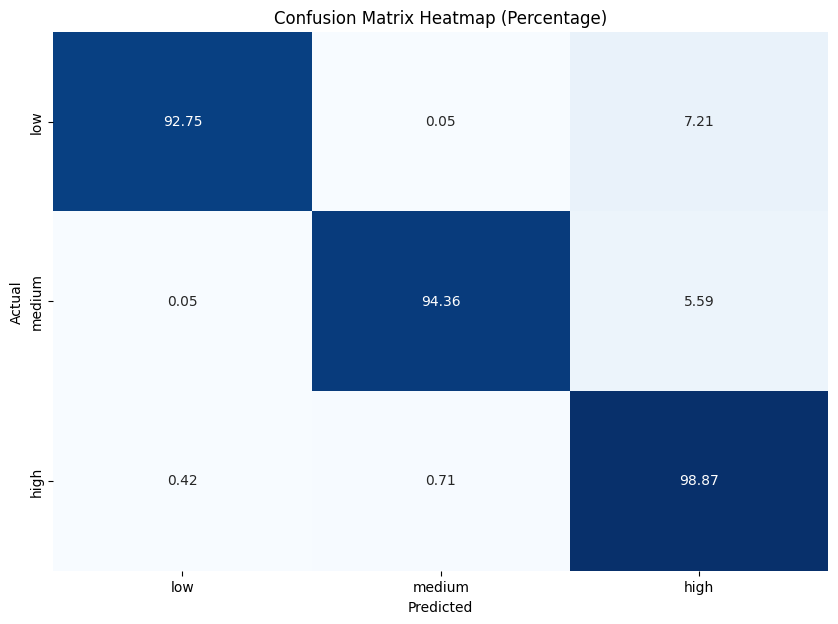

In [27]:
# Get the best model
best_model = grid_search.best_estimator_
# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
# Calculate confusion matrix as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()

## Naive Bayes

In [9]:
# model with default parameters trial
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.6641310537150866


#### Naive Bayes Best Param

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
model = GaussianNB()
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=8)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test set score with best parameters: ", test_score)

Best parameters found:  {'var_smoothing': 1e-07}
Best cross-validation score:  0.6667318466988089
Test set score with best parameters:  0.6671350980420785


#### Naive Bayes ROC

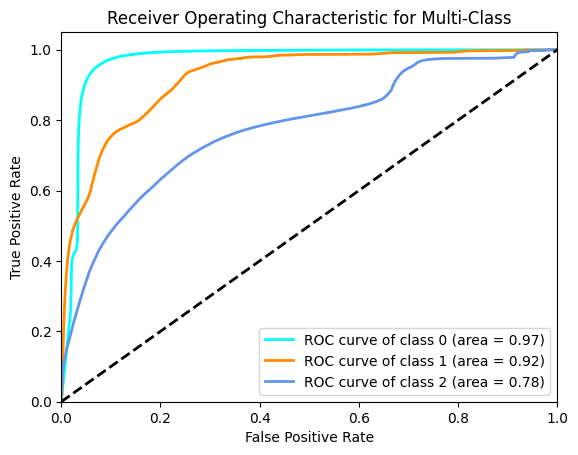

In [11]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined
# Binarize the output (for multi-class)
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Use the OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train_scaled, y_train_binarized)

# Predict probabilities
y_test_prob = ovr_classifier.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

#### Naive Bayes Confussion Matrix

Confusion Matrix:
[[ 11511      0  20341]
 [   563    982  66068]
 [  4089    132 170278]]


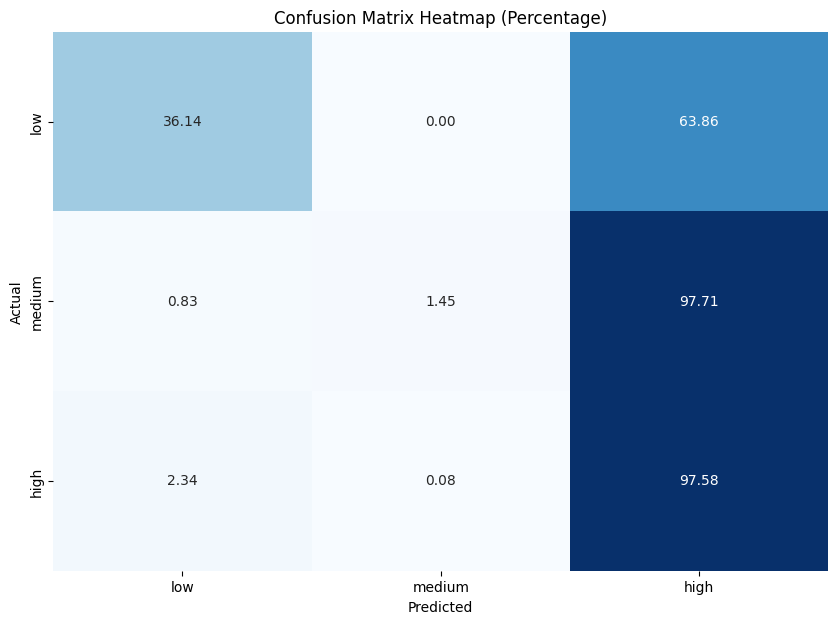

In [12]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate confusion matrix as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()

## Logistic Regression

#### Logistic Regression Best Param with accuarcy

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100],          # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'saga'] # Algorithm to use in the optimization problem
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=8)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test set score with best parameters: ", test_score)

Best parameters found:  {'C': 10, 'solver': 'newton-cg'}
Best cross-validation score:  0.9138440804420684
Test set score with best parameters:  0.9148866274401016


#### Logistic Regression ROC

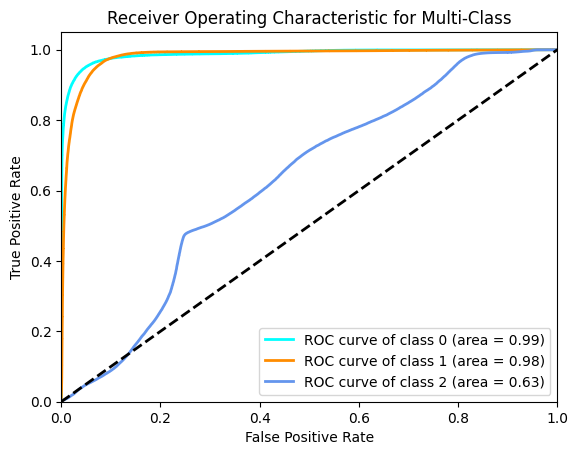

In [14]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined
# Binarize the output (for multi-class)
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Use the OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train_scaled, y_train_binarized)

# Predict probabilities
y_test_prob = ovr_classifier.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


#### Logistic Regression Confusion Matrix

Confusion Matrix:
[[ 27072    154   4626]
 [    70  59673   7870]
 [  2470   8128 163901]]


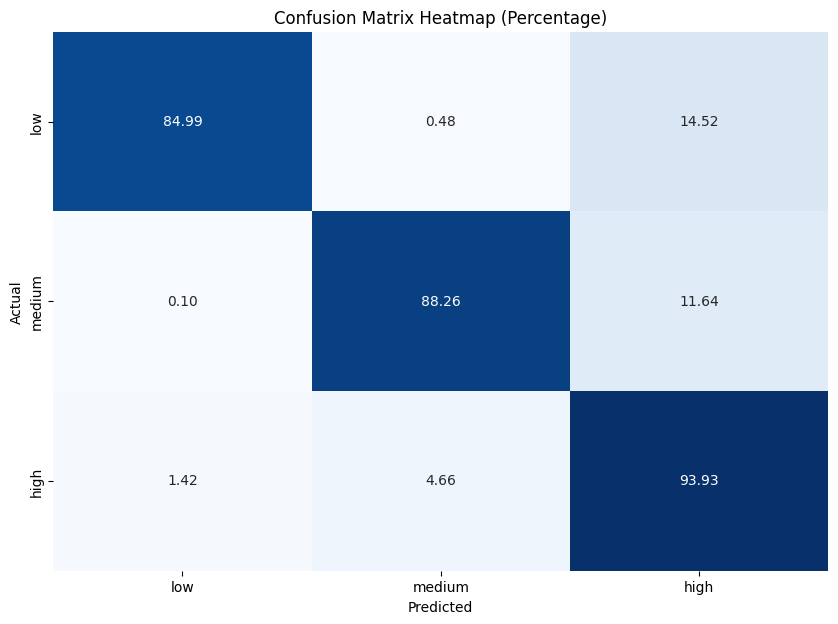

In [15]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate confusion matrix as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()


#### Logistic Regression F1 micro

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100],          # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'saga'] # Algorithm to use in the optimization problem
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_micro', n_jobs=8)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test_scaled)
f1_test = f1_score(y_test, test_predictions, average='micro')  # Adjust average parameter here
print("Test set F1 score with best parameters: ", f1_test)

Best parameters found:  {'C': 10, 'solver': 'newton-cg'}
Best cross-validation score:  0.9138440804420684
Test set F1 score with best parameters:  0.9148866274401016


#### Logistic Regression F1 micro ROC

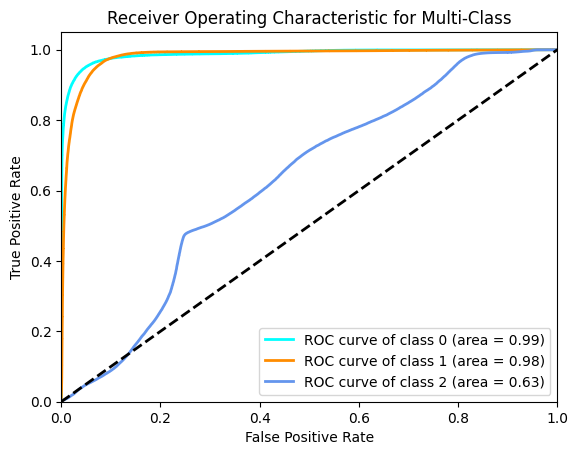

In [17]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined
# Binarize the output (for multi-class)
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Use the OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train_scaled, y_train_binarized)

# Predict probabilities
y_test_prob = ovr_classifier.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


#### Logistic Regression F1 micro confusion Matrix

Confusion Matrix:
[[ 27072    154   4626]
 [    70  59673   7870]
 [  2470   8128 163901]]


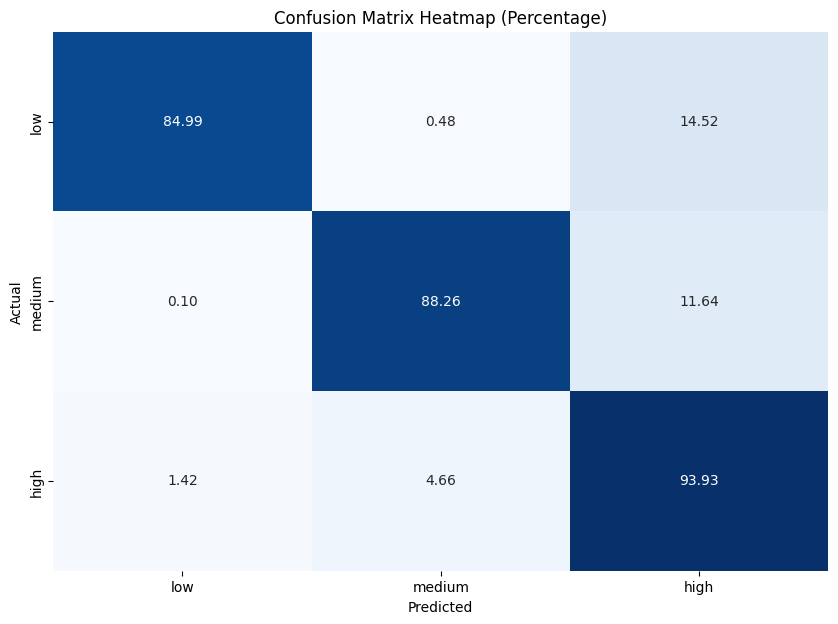

In [18]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate confusion matrix as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9149778803054416


## Decision Trees

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9717846140368808


#### Decision Trees Best Param

In [28]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20],
    'min_samples_leaf': [100, 500, 1000],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs= 8)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test set score with best parameters: ", test_score)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 100, 'splitter': 'best'}
Best cross-validation score:  0.9732576403369965
Test set score with best parameters:  0.9745477507993751


#### Decision Tress ROC

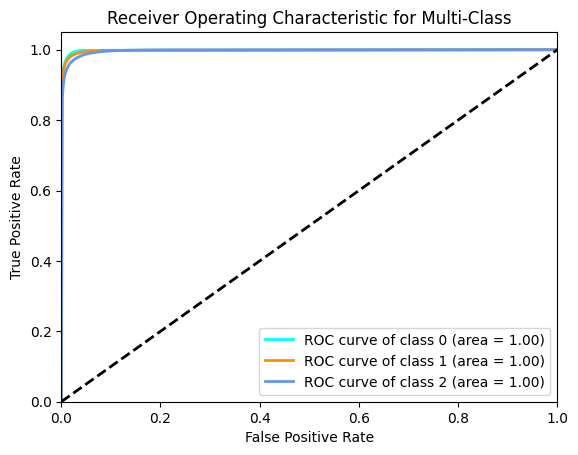

In [29]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined
# Binarize the output (for multi-class)
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Use the OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train_scaled, y_train_binarized)

# Predict probabilities
y_test_prob = ovr_classifier.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

#### Decision Trees Confusion Matrix

Confusion Matrix:
[[ 30258     49   1545]
 [    79  65228   2306]
 [  1108   1886 171505]]


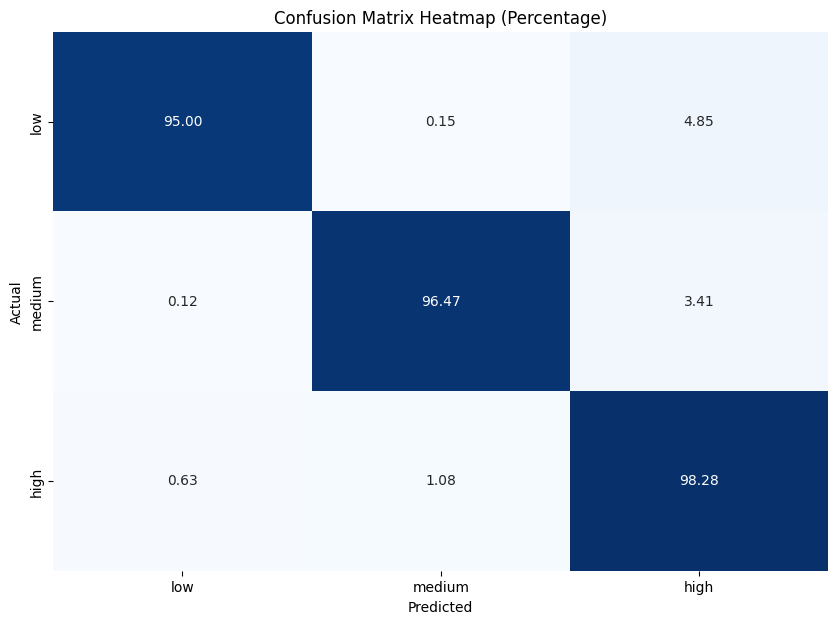

In [30]:
# Get the best model
best_model = grid_search.best_estimator_
# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
# Calculate confusion matrix as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()

## Random Forests

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9802565300550438


#### Random Forests Best Param

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 30],
    'min_samples_leaf': [100, 500, 1000],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=8)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test set score with best parameters: ", test_score)

Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 100, 'n_estimators': 300}
Best cross-validation score:  0.9691809751502379
Test set score with best parameters:  0.9704559723175308


#### Random Forests ROC

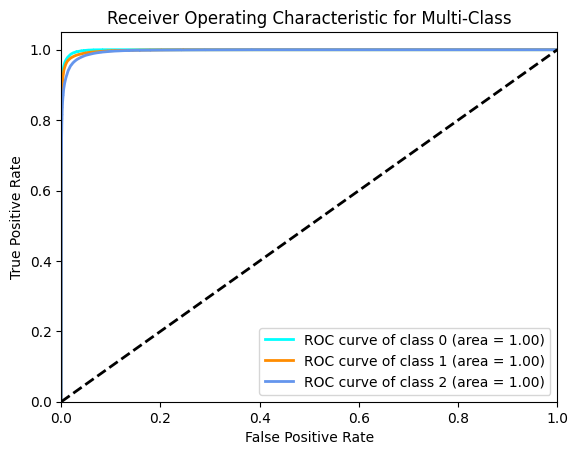

In [25]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined
# Binarize the output (for multi-class)
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Use the OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train_scaled, y_train_binarized)

# Predict probabilities
y_test_prob = ovr_classifier.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

#### Random Forests Confusion Matrix

Confusion Matrix:
[[ 29542     15   2295]
 [    35  63801   3777]
 [   730   1242 172527]]


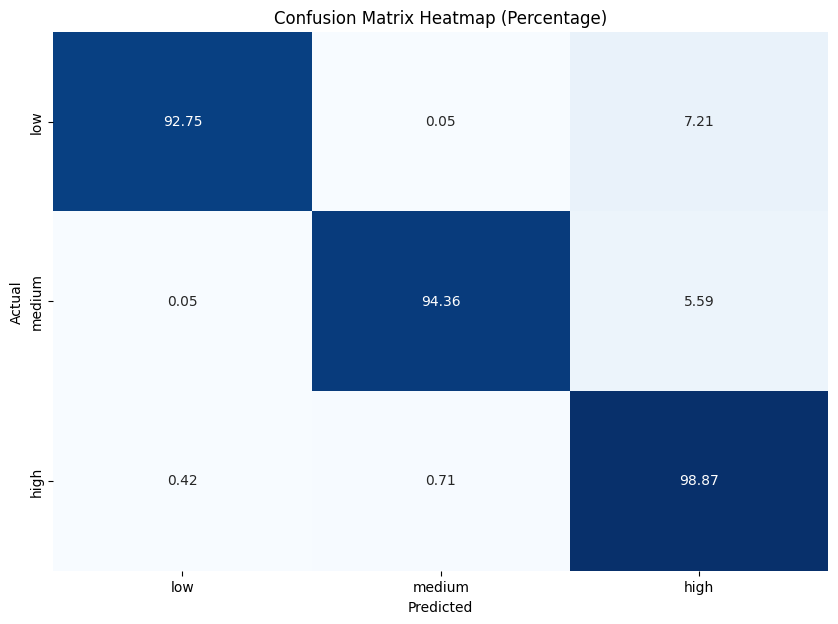

In [26]:
# Get the best model
best_model = grid_search.best_estimator_
# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
# Calculate confusion matrix as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()

## Comments

1- All the reusults show cross-validation score same as test score so the models were not overfitting

2- The best score achieved with desicion trees of around 97%. This result is almost same as random forest however desision trees are far less time consuming.

3- Using F1 score rather than accuracy did not make any difference in the results in logistic regression so it was not necessary to apply it with other models.
